# 1-D Heat Equation

**강좌**: *기초 전산유체역학*

## Heat Equation (1-D)
열전도에 의한 열유속 (Heat Flux)는 Fourier Law에 의해 표현할 수 있다.

$$
\dot{q} = -k \frac{dT}{dx}
$$

여기서 $T$는 온도, $k$ 는 열전도 계수이고, $\dot{q}$ 는 열유속 ($W/m^2$) 이다.

단위 길이 $\Delta x$ 에 대해서 내부에너지 변화는 열유속의 구배와 같다.

$$
\rho C_p \frac{dT}{dt} = \lim_{\Delta x \rightarrow 0} 
\frac{\dot{q} + \dot{q}_x \Delta x - \dot{q}}{\Delta x} = -k \frac{d^2T}{dx^2}
$$

이를 정리하면 1차원 Heat equation 이다.

$$
\frac{dT}{dt} = \alpha \frac{d^2T}{dx^2}.
$$

:::{figure-md} markdown-fig
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Heat-conduction.svg" alt="conduction-fig">

Heat Conduction (image from wikimedia.org)
:::

## Finite Difference Method
Linear Wave 방정식 해석과 같이 Finite Difference 를 이용해서 이 편미분 방정식을 차분한다.

### FTCS (Forward difference in Time, Central difference in Space)
$$
\frac{T(x,t+\Delta t) - T(x, t)}{\Delta t} 
=
\alpha \frac {T(x + \Delta x, t) -2 T(x, t) + T(x - \Delta x, t)}{\Delta x^2} + O((\Delta t), (\Delta x)^2)
$$

여기서 시간과 공간을 각각 M, N 개로 나누고, $(n, i)$ 점에서 값을 다음과 같이 간단히 표시하자

$$
T(x_i, t_n) = T_i^n
$$

:::{figure-md} markdown-fig
<img src="https://i.stack.imgur.com/PihC7.png" alt="stencil-fig">

FTCS Stencil
:::

그 결과 위 차분식 (FDE, Finite Difference Equation)은 다음과 같이 표현할 수 있다.

$$
\frac{T_i^{n+1}- T_i^n}{\Delta t} 
=
\alpha \frac {T_{i+1}^n -2 T_i^n +  T_{i-1}^n}{\Delta x^2}
$$

#### 계산 격자 구성,  Solution array 구성
계산 영역을 $n_x + 1$개의 점으로 나누어보자.

즉 격자점은 다음과 같다.

$$
x_j = 0,  \Delta x, -1 + 2 \Delta x, ..., 1 - \Delta x, 1 ~~(1 \le j \le n_x +1)
$$

:::{figure-md} Grid
<img src="figures/fd_pts2.png">

Grid
:::

첫번째 격자점과 마지막 격자점은 경계조건으로 부여할 수 있다.

$$
T_0^n = T_0 \\
T_{n_x+1}^n = T_N
$$

경계 조건을 위해서 Solution array는 경계조건을 포함해서 격자점 개수와 같이 $n_x+1$ 으로 구성한다. 

계산은 양 끝점을 제외한 $T_1, T_2,... T_{n_x}$ 에 대해서 수행한다.

$$
T_i^{n+1}
=
T_i^n 
+
\frac{\alpha \Delta t}{\Delta x^2}
\left (
{T_{i+1}^n -2 T_i^n +  T_{i-1}^n}
\right )
$$



### 예제
$\alpha=0.1$ 이고 $x\in [0, 1]$ 에 대해서 해석한다.

- 초기 조건 : $T(x,0) = 100$
- 경계 조건 : $T(0, t) = 100$, $T(1, t) = 300$

$\Delta t =0.01, \Delta x=0.1$ 에 $t=1$ 일때 온도 분포를 구하시오.

*참고* Exact Solution은 변수 분리법에 따라 다음과 같다.

$$
T = T_0 + \Delta T x + \sum_{n=1}^{\infty} \frac{2 \Delta T (-1)^n}{n \pi} e^{-n^2 \pi^2 \alpha t} \sin(n \pi x)
$$

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [2]:
def cs(nx, u, du, adtdx2):
    """
    Central difference in space
    
    Parameters
    ----------
    nx : integer
        number of elements in solution array
    u : array
        solution
    du : array
        difference of current and next solution
    adtdx2 : float
        constant
    """
    # DIY
    # du_i = a*dt/dx^2*(u_{i-1} - 2*u_i + u_{i+1}) for i in 1, 2..., nx-2

Error: 0.16054


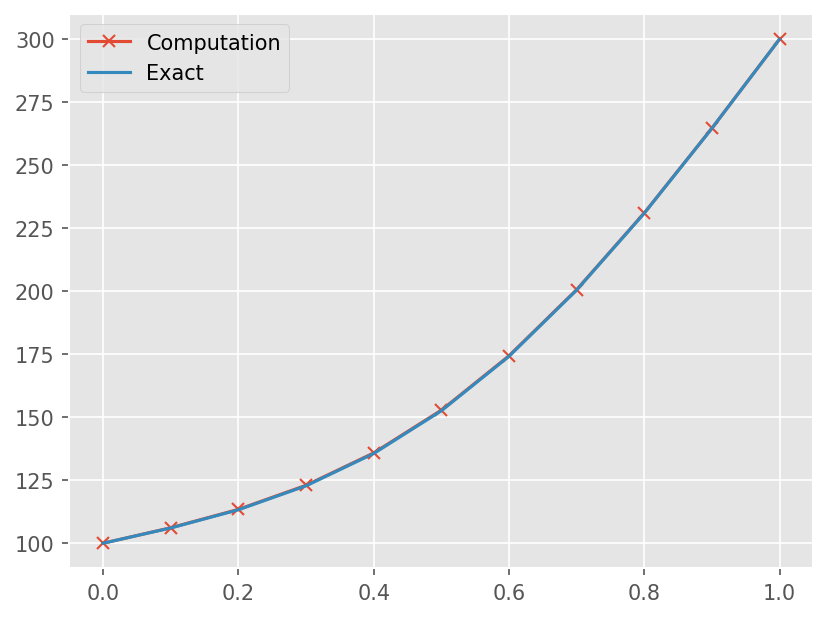

In [3]:
# Conditions
alpha = 0.1
ti = 100
ts = 300

t_target = 1.0
dt = 0.01

# Make grid
nx = 11
x = np.linspace(0, 1, nx)
dx = np.diff(x)[0]

# Const
adx2 = alpha / dx**2

# Solution array
u = np.ones_like(x)*ti
du = np.zeros_like(u)

# Calculation
t = 0
while abs(t - t_target) > 1e-10:
    # Adjust time step to reach target time
    dt = min(dt, t_target - t)

    # Apply bc
    u[0] = ti
    u[-1] = ts
    
    # Spatial discretization
    cs(nx, u, du, adx2*dt)
    
    # Update solution and time
    u += du
    t += dt

# Exact solution
dts = ts - ti
u_exact = ti + dts*x + np.sum([
    2*dts*(-1)**n / (n*np.pi) *np.exp(-n**2*np.pi**2*alpha*t)*np.sin(n*np.pi*x) 
    for n in range(1, 10)
], axis=0)

# Visualization
plt.plot(x, u, marker='x')
plt.plot(x, u_exact)
plt.legend(['Computation', 'Exact'])

# Compute Error
err = np.linalg.norm(u[1:-1] - u_exact[1:-1])
err = u - u_exact
err = np.sqrt(np.sum(err**2) / nx)
print('Error: {:.5f}'.format(err))

### Accuracy, Stability Convergence

#### 정확도
FTCS 의 Truncation Error 는 $O((\Delta t), (\Delta x)^2)$ 이다.
즉 시간 차분에 대해서는 1차 정확도, 공간 차분에 대해서 2차 정확도를 갖는다. 

Exact solution 과의 오차는 다음과 같이 계산한다.

$$
L_2 Error = \sqrt{\frac{1}{N} \sum (T-T_{exact})^2}
$$

선형 편미분 방정식이므로, Linear Wave 방정식과 같이 Consistency, stability 분석이 가능하다.

또한 이를 통해 수치 해석 결과가 이론 해로 수렴 (Convergence) 하는지 확인할 수 있다.

#### von Neumann Stability

FDE (Finite Difference Equation) 의 완전해를 $D$ 라 했을 때 수치해 $N$은 다음과 같이 나타낼 수 있다.

$$
N = D + \epsilon.
$$

여기서 $\epsilon$ 은 round-off 에 의한 error 이다.

이를 차분식에 적용하면, $D$ 은 차분식을 만족하므로 사라지고, $\epsilon$ 만 남는다.

이 오차를 다음과 같은 형태로 표현하자.

$$
\epsilon_j^n = \sigma^n e^{ikx_j}
$$

이를 차분식에 적용하면

$$
\frac{\sigma^{n+1} e^{ikx_j} - \sigma^n e^{ikx_j}}{\Delta t} 
=
\alpha \frac {\sigma^n e^{ikx_{j+1}} -2 \sigma^n e^{ikx_j} +  \sigma^n e^{ikx_{j-1}}}{\Delta x^2}
$$

정리하면

$$
\sigma = 1 + \frac{\alpha \Delta t}{\Delta x^2} (2 \cos (k\Delta x) - 2)
$$

$|\sigma| < 1$ 을 만족하기 위해서는

$$
\frac{\alpha \Delta t}{\Delta x^2} (2 \cos (k\Delta x) - 2) \geq -2
$$

즉 

$$
\Delta t \leq \frac{\Delta x^2}{\alpha (1 - \cos (k\Delta x))} \leq \frac{\Delta x^2}{2 \alpha}
$$

### Convergence

- Consistency와 Stability를 만족하므로 Lax Equivalance Theorem에 의해 수치해가 이론해에 수렴함을 알 수 있다.

### Du Fort-Frankel Method
FTCS에서 시간에 대해서도 Central Difference를 하면

$$
\frac{T_i^{n+1}- T_i^{n-1}}{2 \Delta t} 
=
\alpha \frac {T_{i+1}^n -2 T_i^n +  T_{i-1}^n}{\Delta x^2}
$$

이 기법은 Unconditionally unstable 하다.

수치 안정성을 확보하기 위해 우변 항을 변화하면 Du Fort-Frankel 기법이다.

$$
\frac{T_i^{n+1}- T_i^{n-1}}{2 \Delta t} 
=
\alpha \frac {T_{i+1}^n -2 \frac{T_i^{n+1} + T_i^{n-1}}{2} +  T_{i-1}^n}{\Delta x^2}
$$

이 기법은 Unconditionally stable 하다.

Talyor expansion을 이용해 Truncation Error을 확인하면

$$
\frac{\partial T}{\partial t} - \alpha \frac{\partial^2 T}{\partial x^2}
=
-\frac{\Delta t^2}{6}\frac{\partial^3 T}{\partial t^3}
+\frac{\alpha \Delta x^2}{12}\frac{\partial^4 T}{\partial t^4}
+\frac{\alpha \Delta t^2}{\Delta x^2}\frac{\partial^4 2}{\partial t^2}
+...
$$

$\Delta t \rightarrow 0$, $\Delta x \rightarrow 0$ 으로 점근하더라도 Truncation Error는 사라지지 않는다.

즉 Consistency를 만족하지 않는다.

## 실습
1. FTCS 기법을 완성하시오.

2. FTCS 기법에 대해서 $\Delta t$ 를 바꿔가면서 von Neumann Stability Analysis 결과를 확인하시오.

3. $\Delta t=10^{-5}$ 로 매우 작게 정하자. 이때 $\Delta x=0.1, 0.05, 0.025, 0.0125$ 로 바꿔가면서 오차를 구하시오. 공간에 대해 2차 정확도를 만족하는지 확인하시오.

4. $\Delta x=0.05$ ($n_x=21$) 로 정하자. 이때 $\Delta t=0.01, 0.005, 0.0025, 0.00125$ 로 바꿔가면서 오차를 구하시오. 시간에 대해 1차 정확도를 만족하는지 확인하시오.